In [14]:
# =========================
# Setup & Configuration
# =========================
import os, gc, math, time, random, json, itertools, copy, warnings
from pathlib import Path
from types import SimpleNamespace
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score, fbeta_score,
    top_k_accuracy_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, auc
)

import wandb


# ---- Device & seeding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def seed_everything(seed: int = 42, strict: bool = False, workers_deterministic: bool = False):
    torch.manual_seed(seed)
    if strict:
        random.seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(workers_deterministic)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def seed_worker(_id):
    wseed = torch.initial_seed() % 2**32
    np.random.seed(wseed); random.seed(wseed)

# =========================
# Global Taxonomy
# =========================
BROAD_CLASSES = ["SNI", "SNII", "CV", "AGN", "TDE"]
ORIG2BROAD = {
    "SN Ia":"SNI","SN Ib":"SNI","SN Ic":"SNI",
    "SN II":"SNII","SN IIP":"SNII","SN IIn":"SNII","SN IIb":"SNII",
    "Cataclysmic":"CV","AGN":"AGN","Tidal Disruption Event":"TDE",
}
NUM_CLASSES = len(BROAD_CLASSES)
BROAD2ID = {c:i for i,c in enumerate(BROAD_CLASSES)}
_SUBCLASS_ID2NAME = [
    "SN Ia","SN Ib","SN Ic","SN II","SN IIP","SN IIn","SN IIb",
    "Cataclysmic","AGN","Tidal Disruption Event"
]
ID2BROAD_ID = {i:BROAD2ID[ORIG2BROAD[name]] for i,name in enumerate(_SUBCLASS_ID2NAME)}

Device: cuda


In [15]:
# =========================
# Configuration (EDIT HERE)
# =========================
CFG = SimpleNamespace(
    # --- data
    output_dir      = '/work/hdd/bcrv/ffontinelenunes/data/AppleCider/photo_events',
    stats_file      = 'feature_stats_day100.npz',
    horizon_days    = 50.0,
    batch_size      = 256,
    sampler_balance = True,
    num_workers     = 8,

    # --- model
    d_model   = 128,
    n_heads   = 8,
    n_layers  = 4,
    dropout   = 0.40,
    max_len   = 257,
    use_time2vec = True,

    # --- base optimizer (only used by train loop)
    lr           = 2e-4,
    weight_decay = 1e-2,

    # --- loss/imbalance
    focal_gamma = 2.0,

    # --- augmentation
    cut_time_p   = None,     # if used, (.25,.25,.25,.25)
    p_dropout    = 0.10,
    jitter_scale = 0.10,
    flux_nu      = 8,

    # --- training schedule
    epochs   = 150,
    patience = 30,

    # --- reproducibility
    seed   = 666,
    strict_seed           = False,
    workers_deterministic = False,

    # --- optional toggles
    use_pretrained_encoder   = True, # set to true to strart from ME-PT ckpt
    pretrained_path          = "mpt_encoder.pt",

    # --- calibration (optional)
    calibrate_with_temperature = True,
    calib_bins = 15,

    # --- fine-tuning strategies
    # choose: "full" or "head_then_full"
    finetune_strategy         = "full",
    # Strategy A (FULL)
    ft_full_lr                = 2e-4,
    ft_full_weight_decay      = 1e-2,
    # Strategy B (HEAD -> FULL)
    h2f_head_epochs           = 5,
    h2f_head_lr               = 1e-2,
    h2f_head_weight_decay     = 1e-2,
    h2f_full_encoder_lr       = 5e-5,
    h2f_full_head_lr          = 5e-4,
    h2f_full_weight_decay     = 1e-2,

    # --- cross-validation (optional)
    k_folds     = 2,      # set to None to disable CV
    fold_index  = 0,

    # --- hyperparam search (optional)
    hps_enabled  = True,
    hps_max_trials = 2,   # very small, just for smoke test
    hps_grid = None,

    # --- logging (w/ W&B)
    wandb_mode      = "online", #"disabled",to not log externally
    wandb_project   = "photometry_example",
    wandb_run_name  = None,         
)

seed_everything(CFG.seed, strict=CFG.strict_seed, workers_deterministic=CFG.workers_deterministic)


# Dataset, Dataloaders & friends

In [16]:
# =========================
# Data (dataset, manifests, loaders)
# =========================
_BAND_OH = np.eye(3, dtype=np.float32)

def build_event_tensor(arr):
    # arr: columns [t, dt, band_idx, logf, logfe]
    dt  = np.log1p(arr[:,0]);  dt_prev = np.log1p(arr[:,1])
    logf, logfe = arr[:,3], arr[:,4]
    oh   = _BAND_OH[arr[:,2].astype(np.int64)]
    vec4 = np.stack([dt, dt_prev, logf, logfe], 1)
    return torch.from_numpy(np.concatenate([vec4, oh], 1))  # (L, 7)

class PhotoEventDataset(Dataset):
    def __init__(self, manifest_df, horizon=10.0):
        self.df = manifest_df.reset_index(drop=True)
        self.horizon = horizon
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        raw = np.load(row.filepath)
        arr = raw['data'] if isinstance(raw, np.lib.npyio.NpzFile) else raw
        if self.horizon:
            arr = arr[arr[:,0] <= self.horizon]
        return build_event_tensor(arr.astype(np.float32)), ID2BROAD_ID[int(row.label)]

def load_stats(path: Path):
    st = np.load(path)
    return (torch.from_numpy(st['mean']), torch.from_numpy(st['std']))

def build_collate(mean, std):
    def collate(batch):
        seqs, labels = zip(*batch)
        lens = [s.size(0) for s in seqs]
        pad  = pad_sequence(seqs, batch_first=True)              # (B, L, 7)
        mask = torch.stack([torch.cat([torch.zeros(l), torch.ones(pad.size(1)-l)]) for l in lens]).bool()
        cont = (pad[...,:4] - mean) / (std + 1e-8)
        return torch.cat([cont, pad[...,4:]], -1), torch.tensor(labels), mask  # x, y, pad_mask
    return collate

def _read_default_manifests(cfg):
    out = Path(cfg.output_dir)
    train_df = pd.read_csv(out / "manifest_train.csv")
    val_df   = pd.read_csv(out / "manifest_val.csv")
    test_df  = pd.read_csv(out / "manifest_test.csv")
    return train_df, val_df, test_df

def _build_kfold_manifests(cfg):
    base_train, base_val, test_df = _read_default_manifests(cfg)
    full = pd.concat([base_train, base_val], ignore_index=True)
    y    = full.label.map(ID2BROAD_ID).values
    skf = StratifiedKFold(n_splits=cfg.k_folds, shuffle=True, random_state=cfg.seed)
    tr_idx, va_idx = list(skf.split(np.zeros(len(full)), y))[cfg.fold_index]
    train_df = full.iloc[np.sort(tr_idx)].reset_index(drop=True)
    val_df   = full.iloc[np.sort(va_idx)].reset_index(drop=True)
    return train_df, val_df, test_df

def _get_manifests(cfg):
    return _read_default_manifests(cfg) if not cfg.k_folds else _build_kfold_manifests(cfg)

class BalancedAugDataset(Dataset):
    """
    Optional: oversample a minority class (mainly TDE) with light augmentations.
    Controlled via CFG.enable_balanced_aug.
    """
    def __init__(self, manifest_df, labels, target_per_class,
                 horizon=10.0, p_dropout=0.1, jitter_scale=0.02, flux_nu=4):
        self.base_ds       = PhotoEventDataset(manifest_df, horizon)
        self.df            = manifest_df.reset_index(drop=True)
        self.labels        = labels
        self.target        = target_per_class
        self.horizon       = horizon
        self.p_dropout     = p_dropout
        self.jitter_scale  = jitter_scale
        self.flux_nu       = flux_nu

        self.tde_idx       = BROAD2ID["TDE"]
        orig_tde_idxs      = np.where(labels == self.tde_idx)[0].tolist()
        extras             = max(0, target_per_class - len(orig_tde_idxs))
        self.indices       = list(range(len(self.base_ds))) + list(np.random.choice(orig_tde_idxs, extras, replace=True))

    def __len__(self): return len(self.indices)

    def __getitem__(self, i):
        ds_idx = self.indices[i]
        tensor, label = self.base_ds[ds_idx]
        if label == self.tde_idx and i >= len(self.base_ds):
            row = self.df.iloc[ds_idx]
            raw = np.load(row.filepath)
            arr = raw['data'] if isinstance(raw, np.lib.npyio.NpzFile) else raw
            arr = arr[arr[:,0] <= self.horizon]
            if len(arr) == 0: arr = arr[:1]
            keep = np.random.rand(len(arr)) > self.p_dropout
            keep[0] = True
            arr = arr[keep]
            if len(arr) == 0: arr = arr[:1]
            t0 = arr[:,0]
            ints = np.diff(np.concatenate([[0.], t0]))
            noise = np.random.randn(len(ints)) * (self.jitter_scale * (ints + 1e-6))
            ints = np.clip(ints + noise, 0, None)
            tnew = np.cumsum(ints)
            arr[:,0] = tnew
            arr[:,1] = np.concatenate([[0.], ints[:-1]])
            from scipy.stats import t as student_t
            logf, logfe = arr[:,3], arr[:,4]
            f, ferr     = np.exp(logf), np.exp(logfe)
            fnew        = student_t(df=CFG.flux_nu, loc=f, scale=0.15 * ferr).rvs()
            arr[:,3]    = np.log(np.clip(fnew, 1e-8, None))
            tensor = build_event_tensor(arr.astype(np.float32))
        return tensor, label

def make_loaders(cfg):
    mean, std = load_stats(Path(cfg.output_dir) / cfg.stats_file)
    collate   = build_collate(mean, std)

    train_df, val_df, test_df = _get_manifests(cfg)

    gen = None
    if cfg.strict_seed:
        gen = torch.Generator(); gen.manual_seed(cfg.seed)

    # Choose dataset and sampling
    if getattr(cfg, "enable_balanced_aug", False):
        orig_lbls = train_df.label.map(ID2BROAD_ID).values
        counts    = np.bincount(orig_lbls, minlength=NUM_CLASSES)
        ref_idx   = BROAD2ID["SNII"]
        target    = int(counts[ref_idx])
        train_ds  = BalancedAugDataset(train_df, orig_lbls, target,
                                       horizon=cfg.horizon_days,
                                       p_dropout=cfg.p_dropout,
                                       jitter_scale=cfg.jitter_scale,
                                       flux_nu=cfg.flux_nu)
        all_labels = [orig_lbls[i] for i in getattr(train_ds, "indices")]
        freqs = Counter(all_labels)
        sample_weights = [1.0/freqs[l] for l in all_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_ld = DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler,
                              num_workers=cfg.num_workers, collate_fn=collate, pin_memory=True,
                              generator=gen, worker_init_fn=seed_worker if cfg.strict_seed else None)
    else:
        train_ds = PhotoEventDataset(train_df, cfg.horizon_days)
        if cfg.sampler_balance:
            lbl     = train_df.label.map(ID2BROAD_ID).values
            weights = 1/np.sqrt(np.bincount(lbl, minlength=NUM_CLASSES))[lbl]
            sampler = WeightedRandomSampler(torch.from_numpy(weights).float(),
                                            len(weights), replacement=True)
            train_ld= DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler,
                                 num_workers=cfg.num_workers, collate_fn=collate, pin_memory=True,
                                 generator=gen, worker_init_fn=seed_worker if cfg.strict_seed else None)
        else:
            train_ld= DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                                 num_workers=cfg.num_workers, collate_fn=collate, pin_memory=True,
                                 generator=gen, worker_init_fn=seed_worker if cfg.strict_seed else None)

    val_ds  = PhotoEventDataset(val_df,  cfg.horizon_days)
    test_ds = PhotoEventDataset(test_df, cfg.horizon_days)

    val_ld  = DataLoader(val_ds,  batch_size=cfg.batch_size, shuffle=False,
                         num_workers=cfg.num_workers, collate_fn=collate, pin_memory=True,
                         generator=gen, worker_init_fn=seed_worker if cfg.strict_seed else None)
    test_ld = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                         num_workers=cfg.num_workers, collate_fn=collate, pin_memory=True,
                         generator=gen, worker_init_fn=seed_worker if cfg.strict_seed else None)
    return train_ld, val_ld, test_ld, train_df, val_df, test_df


# Torch model definitions

In [17]:
# =========================
# Model
# =========================
class Time2Vec(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.w0 = nn.Parameter(torch.randn(1))
        self.b0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.Parameter(torch.randn(d_model-1))
        self.b  = nn.Parameter(torch.zeros(d_model-1))
    def forward(self, t):  # (B, L)
        v0 = self.w0 * t + self.b0
        vp = torch.sin(t.unsqueeze(-1) * self.w + self.b)
        return torch.cat([v0.unsqueeze(-1), vp], dim=-1)

class BaselineCLS(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, num_classes, dropout, max_len=None, use_time2vec=True):
        super().__init__()
        self.in_proj  = nn.Linear(7, d_model)
        self.cls_tok  = nn.Parameter(torch.zeros(1,1,d_model))
        self.use_time2vec = use_time2vec
        self.time2vec = Time2Vec(d_model) if use_time2vec else None
        enc_layer = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, n_layers)
        self.norm    = nn.LayerNorm(d_model)
        self.head    = nn.Linear(d_model, num_classes)

    def forward(self, x, pad_mask):
        B,L,_ = x.shape
        h = self.in_proj(x)
        if self.use_time2vec:
            t  = x[...,0]
            te = self.time2vec(t)
            h  = h + te
        tok = self.cls_tok.expand(B,1,-1)
        h   = torch.cat([tok, h], dim=1)
        pad = torch.cat([torch.zeros(B,1,device=pad_mask.device, dtype=torch.bool), pad_mask], dim=1)
        z   = self.encoder(h, src_key_padding_mask=pad)
        return self.head(self.norm(z[:,0]))

def load_pretrained_encoder_(model: nn.Module, path: str):
    pre = torch.load(path, map_location=device)
    sd  = model.state_dict()
    loaded = 0
    for k, v in pre.items():
        if k.startswith("head."):  # skip classifier head
            continue
        if k in sd and sd[k].shape == v.shape:
            sd[k] = v; loaded += 1
    model.load_state_dict(sd)
    print(f"Loaded {loaded} pretrained tensors from {path} (encoder only).")


# Visualization

In [18]:
# =========================
# Plotting helpers 
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_curves(curves, title="Training curves", dpi = 300):
    ep = np.arange(1, len(curves["val_auprc"])+1)
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(ep, curves["train_loss"], label="train/loss")
    ax[0].plot(ep, curves["val_loss"],   label="val/loss")
    ax[0].set(xlabel="epoch", ylabel="loss", title="Loss"); ax[0].legend(frameon=False)
    ax[1].plot(ep, curves["val_auprc"],  label="val/auprc")
    ax[1].plot(ep, curves["val_acc"],    label="val/acc")
    ax[1].set(xlabel="epoch", ylabel="score", title="Validation"); ax[1].set_ylim(0,1.02); ax[1].legend(frameon=False)
    plt.suptitle(title); plt.tight_layout(); plt.show(); plt.close(fig)

def plot_confusion(y_true, y_pred, title="Confusion (norm.)"):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))
    cm_norm = (cm.astype(float)/cm.sum(axis=1, keepdims=True))
    cm_norm[np.isnan(cm_norm)] = 0
    fig, ax = plt.subplots(figsize=(5.5,4.5), dpi = 300)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples",
                xticklabels=BROAD_CLASSES, yticklabels=BROAD_CLASSES, ax=ax)
    ax.set_title(title); ax.set_xlabel("Pred"); ax.set_ylabel("True"); plt.tight_layout(); plt.show(); plt.close(fig)

def plot_roc_pr(y_true, probs, title_prefix="Test"):
    y_oh = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    # ROC
    fig1, ax1 = plt.subplots(figsize=(6,5), dpi = 300)
    for i, cls in enumerate(BROAD_CLASSES):
        fpr, tpr, _ = roc_curve(y_oh[:, i], probs[:, i])
        auc_i = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f"{cls} (AUC={auc_i:.2f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_oh.ravel(), probs.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    ax1.plot(fpr_micro, tpr_micro, 'k--', lw=2.2, label=f"Micro (AUC={auc_micro:.2f})")
    ax1.plot([0,1],[0,1],'k:', alpha=.6)
    ax1.set(xlabel="FPR", ylabel="TPR", title=f"{title_prefix} ROC")
    ax1.legend(frameon=False, fontsize=8); plt.tight_layout(); plt.show(); plt.close(fig1)
    # PR
    fig2, ax2 = plt.subplots(figsize=(6,5), dpi = 300)
    for i, cls in enumerate(BROAD_CLASSES):
        prec, rec, _ = precision_recall_curve(y_oh[:, i], probs[:, i])
        ap_i = average_precision_score(y_oh[:, i], probs[:, i])
        ax2.step(rec, prec, where='post', label=f"{cls} (AP={ap_i:.2f})")
    ap_micro = average_precision_score(y_oh, probs, average="micro")
    ax2.set(xlabel="Recall", ylabel="Precision", title=f"{title_prefix} PR (micro AP={ap_micro:.2f})")
    ax2.set_xlim(0,1); ax2.set_ylim(0,1.02); ax2.legend(frameon=False, fontsize=8)
    plt.tight_layout(); plt.show(); plt.close(fig2)

def plot_reliability_diagram(bin_contrib, title="Reliability"):
    xs, ys = [], []
    for lo, hi, prop, acc_bin, conf_bin in bin_contrib:
        xs.append(conf_bin); ys.append(acc_bin)
    fig, ax = plt.subplots(figsize=(4.5,4.5))
    ax.plot([0,1],[0,1],'--',color='gray',lw=1)
    ax.scatter(xs, ys, s=40)
    ax.set(xlabel="Confidence", ylabel="Accuracy", title=title, xlim=(0,1), ylim=(0,1))
    ax.grid(alpha=0.2); plt.tight_layout(); plt.show(); plt.close(fig)


# Evaluation helpers

In [19]:
# =========================
# Evaluation helpers 
# =========================
@torch.no_grad()
def collect_logits(model, loader):
    ys, logits = [], []
    model.eval()
    for x, y, m in loader:
        x, m = x.to(device), m.to(device)
        out  = model(x, m)
        ys.append(y.numpy())
        logits.append(out.detach().cpu())
    y = np.concatenate(ys)
    L = torch.cat(logits, 0)
    return y, L

def summarize_on_loader(model, loader):
    y, L = collect_logits(model, loader)
    P    = torch.softmax(L, 1).numpy()
    y_oh = label_binarize(y, classes=np.arange(NUM_CLASSES))
    metrics = {
        "acc":   float((P.argmax(1) == y).mean()),
        "auprc": float(average_precision_score(y_oh, P, average="macro")),
        "top2":  float(top_k_accuracy_score(y, P, k=2)),
        "top3":  float(top_k_accuracy_score(y, P, k=3)),
    }
    return metrics, (y, P, L)


# Training utilities

In [20]:
# =========================
# Training 
# =========================
class FocalLoss(nn.Module):
    def __init__(self, gamma: float = 2.0, alpha: torch.Tensor = None, eps: float = 0.1, reduction: str = 'mean'):
        super().__init__()
        self.gamma, self.alpha, self.eps, self.reduction = gamma, alpha, eps, reduction
    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        B, C = logits.shape
        logp = F.log_softmax(logits, dim=1); p = logp.exp()
        if self.eps > 0:
            smooth = torch.full_like(logp, fill_value=self.eps/(C-1))
            smooth.scatter_(1, target.unsqueeze(1), 1.0-self.eps)
            y = smooth
        else:
            y = F.one_hot(target, num_classes=C).float()
        focal_weight = (1.0 - p).pow(self.gamma)
        if self.alpha is not None:
            focal_weight = focal_weight * self.alpha.view(1, C)
        loss = -(y * focal_weight * logp).sum(dim=1)
        return loss.mean() if self.reduction=='mean' else loss.sum()

def _cut_time(mask, dt_first, probs):
    B,_ = mask.shape
    horizons = np.random.choice([1,3,5,10], size=B, p=probs)
    for b,h in enumerate(horizons):
        mask[b, dt_first[b]>h] = True

def run_epoch(model, loader, optimizer, criterion, is_train, cfg: SimpleNamespace):
    if is_train: model.train()
    else:        model.eval()

    tot_loss, tot_correct, tot_N = 0.0, 0, 0
    y_true_list, y_prob_list = [], []

    for x, y, m in loader:
        x, y, m = x.to(device), y.to(device), m.to(device)
        if is_train and cfg.cut_time_p is not None:
            dt_first = x[...,0].exp() - 1
            _cut_time(m, dt_first, cfg.cut_time_p)

        logits = model(x, m)
        loss   = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        tot_loss    += loss.item() * y.size(0)
        tot_correct += (logits.argmax(1) == y).sum().item()
        tot_N       += y.size(0)

        y_true_list.append(y.detach().cpu().numpy())
        y_prob_list.append(torch.softmax(logits, 1).detach().cpu().numpy())

    y_true = np.concatenate(y_true_list)
    y_prob = np.concatenate(y_prob_list)
    y_true_oh = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    auprc_macro = average_precision_score(y_true_oh, y_prob, average='macro')
    return tot_loss/tot_N, tot_correct/tot_N, auprc_macro

def build_model_and_criterion(cfg, train_df):
    model = BaselineCLS(
        cfg.d_model, cfg.n_heads, cfg.n_layers,
        NUM_CLASSES, cfg.dropout, cfg.max_len,
        use_time2vec=getattr(cfg, "use_time2vec", True)
    ).to(device)
    if cfg.use_pretrained_encoder:
        load_pretrained_encoder_(model, cfg.pretrained_path)
    cnts  = torch.bincount(torch.tensor(train_df.label.map(ID2BROAD_ID).values), minlength=NUM_CLASSES)
    alpha = (1/torch.sqrt(cnts+1e-6)).to(device)
    crit  = FocalLoss(cfg.focal_gamma, alpha)
    return model, crit

def _train_epochs(model, crit, train_ld, val_ld, optimizer, cfg, tag="fit"):
    best_auprc, best_state, no_improve = -1.0, None, 0
    curves = {"train_loss": [], "val_loss": [], "val_auprc": [], "val_acc": []}
    for ep in range(1, cfg.epochs+1):
        tr_loss, tr_acc, tr_auprc = run_epoch(model, train_ld, optimizer, crit, True,  cfg)
        va_loss, va_acc, va_auprc = run_epoch(model,   val_ld, None,      crit, False, cfg)
        curves["train_loss"].append(tr_loss)
        curves["val_loss"].append(va_loss)
        curves["val_auprc"].append(va_auprc)
        curves["val_acc"].append(va_acc)
        if va_auprc > best_auprc + 1e-4:
            best_auprc = va_auprc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                print(f"[{tag}] Early stop @ epoch {ep} | best val AUPRC={best_auprc:.4f}")
                break
        print(f"[{tag}] EP{ep:03d} | tl {tr_loss:.3f} | vl {va_loss:.3f} | vAUPRC {va_auprc:.3f} | vAcc {va_acc:.3f}")
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, curves, best_auprc

def run_finetune_full(cfg):
    train_ld, val_ld, test_ld, train_df, val_df, test_df = make_loaders(cfg)
    model, crit = build_model_and_criterion(cfg, train_df)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.ft_full_lr, weight_decay=cfg.ft_full_weight_decay)
    model, curves, best_val = _train_epochs(model, crit, train_ld, val_ld, optimizer, cfg, tag="ft_full")
    return {"model": model, "loaders": (train_ld, val_ld, test_ld), "curves": curves, "best_val_auprc": best_val}

def run_finetune_head_then_full(cfg):
    train_ld, val_ld, test_ld, train_df, val_df, test_df = make_loaders(cfg)
    model, crit = build_model_and_criterion(cfg, train_df)
    # Stage 1: head-only
    for n,p in model.named_parameters():
        if not n.startswith("head."): p.requires_grad = False
    head_opt = torch.optim.AdamW(model.head.parameters(), lr=cfg.h2f_head_lr, weight_decay=cfg.h2f_head_weight_decay)
    for ep in range(1, cfg.h2f_head_epochs+1):
        tr_loss, tr_acc, tr_auprc = run_epoch(model, train_ld, head_opt, crit, True,  cfg)
        va_loss, va_acc, va_auprc = run_epoch(model,   val_ld, None,     crit, False, cfg)
        print(f"[HEAD] EP{ep:02d} | tl {tr_loss:.3f} | vl {va_loss:.3f} | vAUPRC {va_auprc:.3f}")
    # Stage 2: unfreeze all and train
    for p in model.parameters(): p.requires_grad = True
    full_opt = torch.optim.AdamW([
        {"params": model.encoder.parameters(), "lr": cfg.h2f_full_encoder_lr},
        {"params": model.head.parameters(),    "lr": cfg.h2f_full_head_lr},
        {"params": model.in_proj.parameters(), "lr": cfg.h2f_full_encoder_lr},
        {"params": model.norm.parameters(),    "lr": cfg.h2f_full_encoder_lr},
        *(([{"params": model.time2vec.parameters(), "lr": cfg.h2f_full_encoder_lr}]) if getattr(model, "time2vec", None) is not None else [])
    ], weight_decay=cfg.h2f_full_weight_decay)
    model, curves, best_val = _train_epochs(model, crit, train_ld, val_ld, full_opt, cfg, tag="h2f_full")
    return {"model": model, "loaders": (train_ld, val_ld, test_ld), "curves": curves, "best_val_auprc": best_val}

def run_finetune(cfg):
    return run_finetune_head_then_full(cfg) if cfg.finetune_strategy == "head_then_full" else run_finetune_full(cfg)


# (optional) Model calibration

In [21]:
# =========================
# Calibration wth temperature scaling. helpers + driver 
# =========================
class TemperatureScaler(nn.Module):
    def __init__(self): super().__init__(); self.log_temp = nn.Parameter(torch.zeros(1))
    def forward(self, logits): return logits / self.log_temp.exp()
    @torch.no_grad()
    def temperature(self): return float(self.log_temp.exp().cpu())

def fit_temperature_on_logits(logits: torch.Tensor, labels: torch.Tensor, max_iter=1000):
    scaler = TemperatureScaler().to(logits.device)
    nll = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([scaler.log_temp], lr=0.25, max_iter=50, line_search_fn='strong_wolfe')
    def closure():
        optimizer.zero_grad()
        loss = nll(scaler(logits), labels)
        loss.backward()
        return loss
    for _ in range(max_iter):
        _ = optimizer.step(closure)
        break
    return scaler

def expected_calibration_error(probs, labels, n_bins=15):
    confidences = probs.max(1)
    predictions = probs.argmax(1)
    accuracies  = (predictions == labels).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece, brier = 0.0, np.mean(np.sum((probs - label_binarize(labels, classes=np.arange(probs.shape[1])))**2, axis=1))
    bin_contrib = []
    for i in range(n_bins):
        in_bin = (confidences > bins[i]) & (confidences <= bins[i+1])
        prop = in_bin.mean()
        if prop > 0:
            acc_bin  = accuracies[in_bin].mean()
            conf_bin = confidences[in_bin].mean()
            ece += prop * abs(acc_bin - conf_bin)
            bin_contrib.append((bins[i], bins[i+1], prop, acc_bin, conf_bin))
    return float(ece), float(brier), bin_contrib

def calibrate_if_enabled(cfg, model, loaders):
    """
    Returns None if disabled; else dict with:
      - 'T': temperature
      - 'val': {'ece_unc','brier_unc','bins_unc', 'ece_cal','brier_cal','bins_cal'}
      - 'test': {'acc_unc','auprc_unc','ece_unc','brier_unc', 'acc_cal','auprc_cal','ece_cal','brier_cal'}
    """
    if not cfg.calibrate_with_temperature:
        return None
    _, val_ld, test_ld = loaders

    # Fit on VAL
    y_v, L_v = collect_logits(model, val_ld)
    scaler = fit_temperature_on_logits(L_v.to(device), torch.tensor(y_v, device=device))
    T = scaler.temperature()

    # VAL pre/post stats
    P_v_uncal = torch.softmax(L_v, 1).numpy()
    ece_v_unc, brier_v_unc, bins_unc = expected_calibration_error(P_v_uncal, y_v, n_bins=cfg.calib_bins)
    with torch.no_grad():
        L_v_cal = scaler(L_v.to(device)).cpu()
    P_v_cal  = torch.softmax(L_v_cal, 1).numpy()
    ece_v_cal, brier_v_cal, bins_cal = expected_calibration_error(P_v_cal, y_v, n_bins=cfg.calib_bins)

    # TEST pre/post stats
    y_t, L_t = collect_logits(model, test_ld)
    y_oh_t   = label_binarize(y_t, classes=np.arange(NUM_CLASSES))
    P_t_unc  = torch.softmax(L_t, 1).numpy()
    acc_unc  = float((P_t_unc.argmax(1) == y_t).mean())
    auprc_unc= float(average_precision_score(y_oh_t, P_t_unc, average="macro"))
    with torch.no_grad():
        L_t_cal = scaler(L_t.to(device)).cpu()
    P_t_cal  = torch.softmax(L_t_cal, 1).numpy()
    acc_cal  = float((P_t_cal.argmax(1) == y_t).mean())
    auprc_cal= float(average_precision_score(y_oh_t, P_t_cal, average="macro"))
    ece_t_unc, brier_t_unc, bins_t_unc = expected_calibration_error(P_t_unc, y_t, n_bins=cfg.calib_bins)
    ece_t_cal, brier_t_cal, bins_t_cal = expected_calibration_error(P_t_cal, y_t, n_bins=cfg.calib_bins)

    return dict(
        T=T,
        val=dict(ece_unc=ece_v_unc, brier_unc=brier_v_unc, bins_unc=bins_unc,
                 ece_cal=ece_v_cal, brier_cal=brier_v_cal, bins_cal=bins_cal),
        test=dict(acc_unc=acc_unc, auprc_unc=auprc_unc, ece_unc=ece_t_unc, brier_unc=brier_t_unc,
                  acc_cal=acc_cal, auprc_cal=auprc_cal, ece_cal=ece_t_cal, brier_cal=brier_t_cal)
    )


# (optional) Hyperparameter search

In [22]:
# =========================
# Tiny Hyper-parameter Search with W&B Sweeps
# =========================
# Returns: (best_cfg, best_out), results

# Silence the notebook-name warning (this path doesn't need to exist)
os.environ.setdefault("WANDB_NOTEBOOK_NAME", "photometry_example_testing.ipynb")

def tiny_hparam_search(cfg, grid=None, max_trials=3, seed=None):
    if getattr(cfg, "wandb_mode", None) != "online":
        raise RuntimeError("Set CFG.wandb_mode='online' and run `wandb login` before calling tiny_hparam_search().")


    def _wb_param_spec(name, default):
        if isinstance(grid, dict) and name in grid:
            spec = grid[name]
            if isinstance(spec, (list, tuple)) and len(spec) == 2 and all(isinstance(x, (int,float)) for x in spec):
                lo, hi = float(spec[0]), float(spec[1])
                if name == "lr":
                    return {"distribution": "log_uniform_values", "min": lo, "max": hi}
                return {"distribution": "uniform", "min": lo, "max": hi}
            if isinstance(spec, (list, tuple)) and len(spec) > 0:
                return {"values": list(spec)}
        if name == "lr":
            return {"distribution": "log_uniform_values", "min": 1e-5, "max": 5e-3}
        if name == "dropout":
            return {"distribution": "uniform", "min": 0.0, "max": 0.5}
        if name == "d_model":
            n_heads = getattr(cfg, "n_heads", 8)
            return {"values": [d for d in [96,128,160,192] if d % n_heads == 0]}
        if name == "n_layers":
            return {"values": [2,3,4,5]}
        return {"values": [default]}

    sweep_config = {
        "name": "tiny-bayes-hparam-search",
        "method": "bayes",
        "metric": {"name": "best_val_auprc", "goal": "maximize"},
        "parameters": {
            "lr":       _wb_param_spec("lr", cfg.lr),
            "dropout":  _wb_param_spec("dropout", cfg.dropout),
            "d_model":  _wb_param_spec("d_model", cfg.d_model),
            "n_layers": _wb_param_spec("n_layers", cfg.n_layers),
        },
        "early_terminate": {"type": "hyperband", "min_iter": 2},
        **({"seed": int(seed)} if seed is not None else {}),
    }

    base_epochs, base_patience = cfg.epochs, cfg.patience
    results = []
    best_holder = {"cfg": None, "out": None, "score": -1.0}

    def _apply_trial_to_cfg(cfg_base, params: dict):
        cfg_i = copy.deepcopy(cfg_base)
        cfg_i.epochs   = max(3, min(8, base_epochs//5))     # short schedule
        cfg_i.patience = max(2, min(4, base_patience//3))
        cfg_i.lr       = float(params.get("lr", cfg.lr))
        cfg_i.dropout  = float(params.get("dropout", cfg.dropout))
        cfg_i.d_model  = int(params.get("d_model", cfg.d_model))
        cfg_i.n_layers = int(params.get("n_layers", cfg.n_layers))
        return cfg_i

    def _record_trial(cfg_i, out, score):
        nonlocal best_holder, results
        score = float(score)
        results.append((cfg_i, None, score))
        if score > best_holder["score"]:
            if best_holder["out"] is not None and "model" in best_holder["out"]:
                try: del best_holder["out"]["model"]
                except: pass
            best_holder = {"cfg": cfg_i, "out": out, "score": score}
        else:
            try: del out["model"]
            except: pass
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()

    def _wb_objective():
        # the agent uses the sweep project
        run = wandb.init(mode=getattr(cfg, "wandb_mode", "online"),
                         name=getattr(cfg, "wandb_run_name", None),
                         config={})
        try:
            params = dict(wandb.config)
            cfg_i  = _apply_trial_to_cfg(cfg, params)
            print(f"\n[W&B] Trial params: lr={cfg_i.lr:.2e}, dropout={cfg_i.dropout:.2f}, "
                  f"d_model={cfg_i.d_model}, n_layers={cfg_i.n_layers}")

            out = run_finetune(cfg_i)

            # Log full curves as time-series 
            curves = out["curves"]
            for ep, (tl, vl, va, vacc) in enumerate(
                zip(curves["train_loss"], curves["val_loss"], curves["val_auprc"], curves["val_acc"]), start=1
            ):
                wandb.log({"epoch": ep, "train/loss": tl, "val/loss": vl, "val/auprc": va, "val/acc": vacc}, step=ep)

            best_ep  = int(np.argmax(curves["val_auprc"])) + 1
            best_val = float(curves["val_auprc"][best_ep-1])
            best_acc = float(curves["val_acc"][best_ep-1])
            wandb.summary.update({"best_epoch": best_ep,
                                  "best_val_auprc": best_val,
                                  "best_val_acc": best_acc})

            _record_trial(cfg_i, out, best_val)
        finally:
            run.finish()

    sweep_id = wandb.sweep(
        sweep=sweep_config,
        project=getattr(cfg, "wandb_project", "sweeps"),
        entity=getattr(cfg, "wandb_entity", None),
    )
    wandb.agent(sweep_id, function=_wb_objective, count=int(max_trials))

    # fail loudly so code doesn't crash cryptically
    if best_holder["out"] is None:
        raise RuntimeError("All W&B sweep trials failed. Check the sweep run pages for stack traces.")

    print(f"\nW&B sweep — best val AUPRC={best_holder['score']:.4f}")
    return (best_holder["cfg"], best_holder["out"]), results


In [23]:
# =========================
# Cross-validation 
# =========================
def run_crossval_finetune(cfg):
    """
    Runs K folds; returns a DataFrame-like dict and per-fold artifacts.
    Each fold calls run_finetune() with cfg.fold_index set.
    """
    assert cfg.k_folds and cfg.k_folds >= 2, "Set CFG.k_folds >= 2"
    fold_summaries, fold_artifacts = [], []
    for fi in range(cfg.k_folds):
        cfg_f = copy.deepcopy(cfg); cfg_f.fold_index = fi
        print(f"\n===== Fold {fi+1}/{cfg.k_folds} ({cfg.finetune_strategy}) =====")
        out = run_finetune(cfg_f)
        # summarize on test with evaluation helpers
        _, _, test_ld = out["loaders"]
        m, (y, P, L) = summarize_on_loader(out["model"], test_ld)
        fold_summaries.append({"fold": fi, **m, "best_val_auprc": out["best_val_auprc"]})
        fold_artifacts.append({"fold": fi, "y": y, "P": P, "curves": out["curves"]})
    df = pd.DataFrame(fold_summaries)
    print("\nCV summary per fold:")
    display(df)
    print("\nCV mean ± std:")
    display(df.describe().loc[["mean","std"]])
    return df, fold_artifacts


# (optional) Masked Event Reconstruction pretraining

In [24]:
# =========================
# Optional: ME-MPT pretraining 
# =========================
MASK_P, PT_EPOCHS, PT_BATCH, PT_LR = 0.30, 50, 256, 5e-4
LAMBDA_F, LAMBDA_B, LAMBDA_DT = 5.0, 3.0, 5.0

def _mask_batch(x, pad_mask):
    masked = torch.zeros_like(pad_mask)
    B, L, _ = x.shape
    for b in range(B):
        valid = (~pad_mask[b]).nonzero(as_tuple=True)[0]
        k = max(int(len(valid)*MASK_P), 3)
        num_each = k // 3; extras = k - 3*num_each
        bands    = x[b, :, 4:7].argmax(-1)
        idxs     = []
        for band in [0,1,2]:
            valid_b = valid[bands[valid]==band]
            if len(valid_b)>0:
                take = min(len(valid_b), num_each)
                perm = torch.randperm(len(valid_b))[:take]
                idxs.append(valid_b[perm])
        if extras>0:
            remaining = torch.cat(idxs) if len(idxs)>0 else torch.tensor([], device=valid.device, dtype=valid.dtype)
            pool = valid[~torch.isin(valid, remaining)]
            if len(pool)>0:
                perm = torch.randperm(len(pool))[:extras]
                idxs.append(pool[perm])
        idx = torch.cat(idxs) if len(idxs)>0 else torch.tensor([], device=valid.device, dtype=valid.dtype)
        if len(idx)>0:
            x[b, idx, 2:7] = 0.0
            masked[b, idx] = True
    return masked

class MPTModel(nn.Module):
    def __init__(self, base_enc: BaselineCLS):
        super().__init__()
        self.encoder    = base_enc.encoder
        d               = base_enc.in_proj.out_features
        self.head_flux  = nn.Linear(d, 1)
        self.head_band  = nn.Linear(d, 3)
        self.head_dt    = nn.Linear(d, 1)
        self.cls_tok    = base_enc.cls_tok
        self.in_proj    = base_enc.in_proj
        self.time2vec   = base_enc.time2vec
    def forward(self, z):
        return self.head_flux(z), self.head_band(z), self.head_dt(z)

def run_pretraining(cfg: SimpleNamespace, outfile="mpt_encoder.pt"):
    out_dir   = Path(cfg.output_dir)
    train_df  = pd.read_csv(out_dir/"manifest_train.csv")
    ds_pt     = PhotoEventDataset(train_df, horizon=100)
    mean,std  = load_stats(out_dir/cfg.stats_file)
    collate   = build_collate(mean, std)

    g = None
    if cfg.strict_seed:
        g = torch.Generator(); g.manual_seed(cfg.seed)

    ld_pt     = DataLoader(ds_pt, batch_size=PT_BATCH, shuffle=True,
                           collate_fn=collate, num_workers=cfg.num_workers,
                           pin_memory=True, generator=g,
                           worker_init_fn=seed_worker if cfg.strict_seed else None)

    enc = BaselineCLS(cfg.d_model, cfg.n_heads, cfg.n_layers, NUM_CLASSES, cfg.dropout, cfg.max_len).to(device)
    mpt = MPTModel(enc).to(device)

    opt = torch.optim.AdamW([
        {'params': enc.encoder.parameters(), 'lr': PT_LR*0.5},
        {'params': list(mpt.head_flux.parameters())+list(mpt.head_band.parameters())+list(mpt.head_dt.parameters()),
         'lr': PT_LR},
    ], weight_decay=1e-2)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=PT_EPOCHS)

    for ep in range(1, PT_EPOCHS+1):
        mpt.train()
        ep_tot = 0.0
        for x_mask, _, pad_mask in ld_pt:
            x_mask, pad_mask = x_mask.to(device), pad_mask.to(device)
            x_orig = x_mask.clone()
            masked_tok = _mask_batch(x_mask, pad_mask)

            emb  = enc.in_proj(x_mask)
            te   = F.dropout(enc.time2vec(x_mask[...,0]), p=cfg.p_dropout) if enc.time2vec is not None else 0.0
            h_in = emb + te if enc.time2vec is not None else emb
            B    = h_in.size(0)
            tok  = enc.cls_tok.expand(B,1,-1)
            h    = torch.cat([tok, h_in], 1)
            pad  = torch.cat([pad_mask.new_zeros((B,1)), pad_mask], 1)

            z_full = enc.encoder(h, src_key_padding_mask=pad)
            h_masked = z_full[:,1:]
            f_hat, b_hat, dt_hat = mpt(h_masked)
            mf = masked_tok.view(-1)

            true_f = x_orig[...,2].view(-1)
            loss_f = F.mse_loss(f_hat.view(-1)[mf], true_f[mf])
            true_b = x_orig[...,4:7].argmax(-1).view(-1)
            loss_b = F.cross_entropy(b_hat.view(-1,3)[mf], true_b[mf])
            dt_gt  = torch.roll(x_orig[...,1], -1, dims=1); dt_gt[:,-1] = 0.
            dt_gt  = dt_gt.view(-1)
            loss_dt= F.mse_loss(dt_hat[...,0].view(-1)[mf], dt_gt[mf])

            loss = LAMBDA_F*loss_f + LAMBDA_B*loss_b + LAMBDA_DT*loss_dt
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(mpt.parameters(), 1.0)
            opt.step()
            ep_tot += float(loss.item())

        sched.step()
        print(f"[MPT] EP{ep:02d} | loss {ep_tot/len(ld_pt):.4f}")

    torch.save(enc.state_dict(), outfile)
    print("Saved pretrained encoder to", outfile)


# Example runs

>> SINGLE FINETUNE
Loaded 57 pretrained tensors from mpt_encoder.pt (encoder only).


/tmp/ipykernel_2967243/2005479492.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(path, map_location=device)


[ft_full] EP001 | tl 0.029 | vl 0.021 | vAUPRC 0.482 | vAcc 0.585
[ft_full] EP002 | tl 0.025 | vl 0.020 | vAUPRC 0.523 | vAcc 0.639
[ft_full] EP003 | tl 0.024 | vl 0.019 | vAUPRC 0.571 | vAcc 0.697
[ft_full] EP004 | tl 0.022 | vl 0.019 | vAUPRC 0.618 | vAcc 0.734
[ft_full] EP005 | tl 0.021 | vl 0.018 | vAUPRC 0.663 | vAcc 0.780
[ft_full] EP006 | tl 0.020 | vl 0.018 | vAUPRC 0.692 | vAcc 0.783
[ft_full] EP007 | tl 0.020 | vl 0.017 | vAUPRC 0.712 | vAcc 0.802
[ft_full] EP008 | tl 0.019 | vl 0.017 | vAUPRC 0.723 | vAcc 0.797
[ft_full] EP009 | tl 0.019 | vl 0.017 | vAUPRC 0.727 | vAcc 0.817
[ft_full] EP010 | tl 0.019 | vl 0.017 | vAUPRC 0.732 | vAcc 0.817


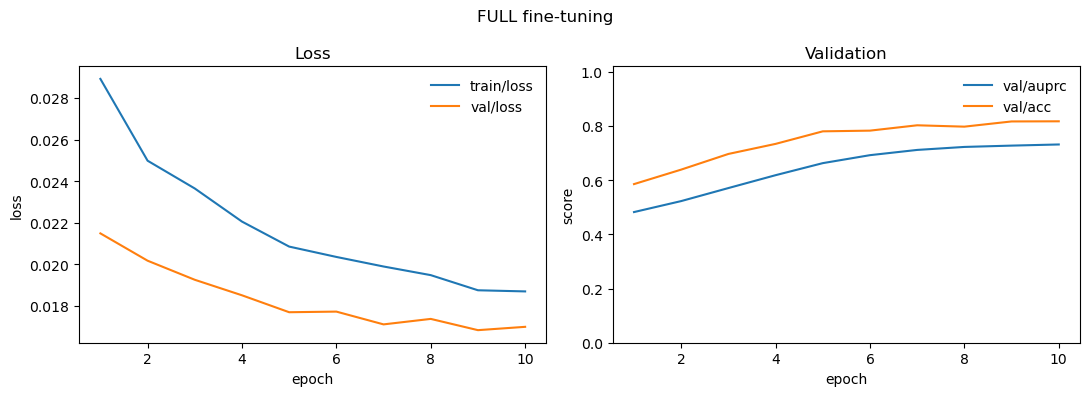

[TEST single]  {'acc': 0.8264523200584581, 'auprc': 0.7284411233804517, 'top2': 0.8947753014249178, 'top3': 0.9444647424187066}


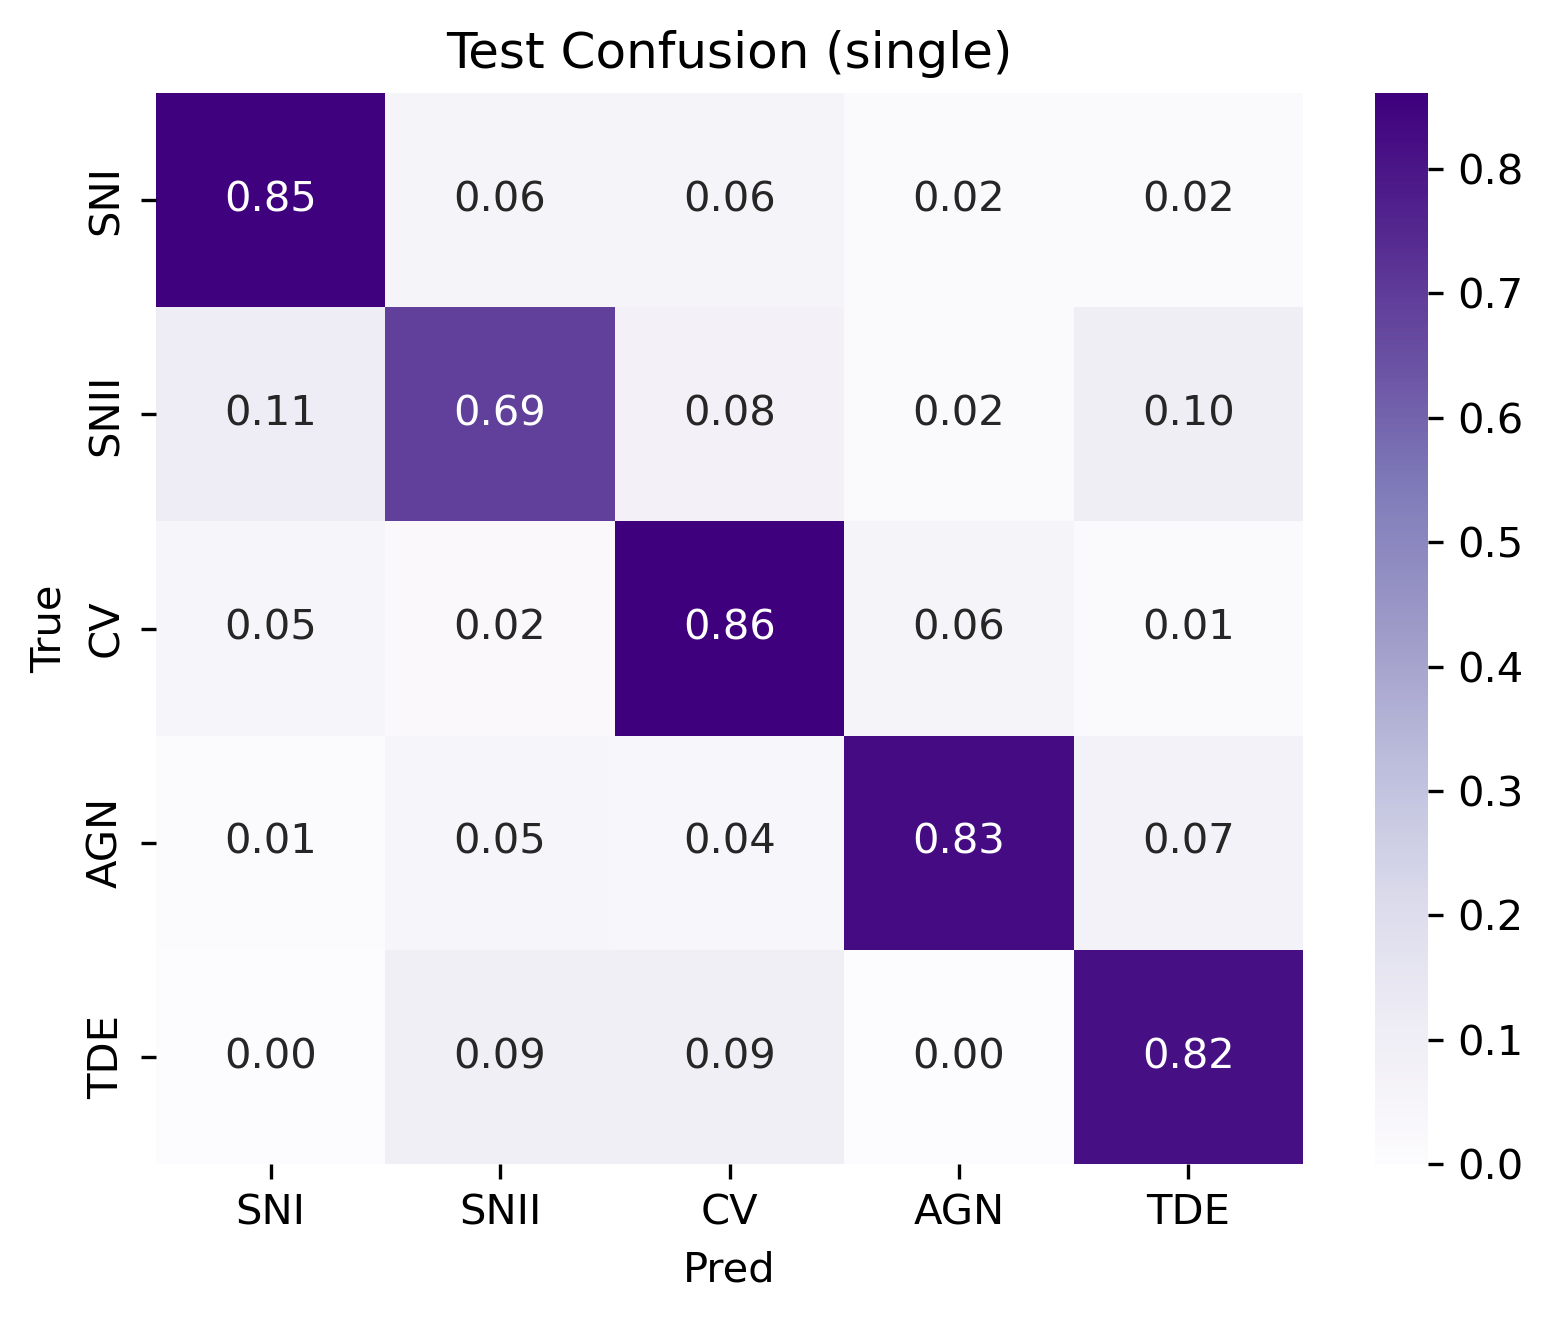

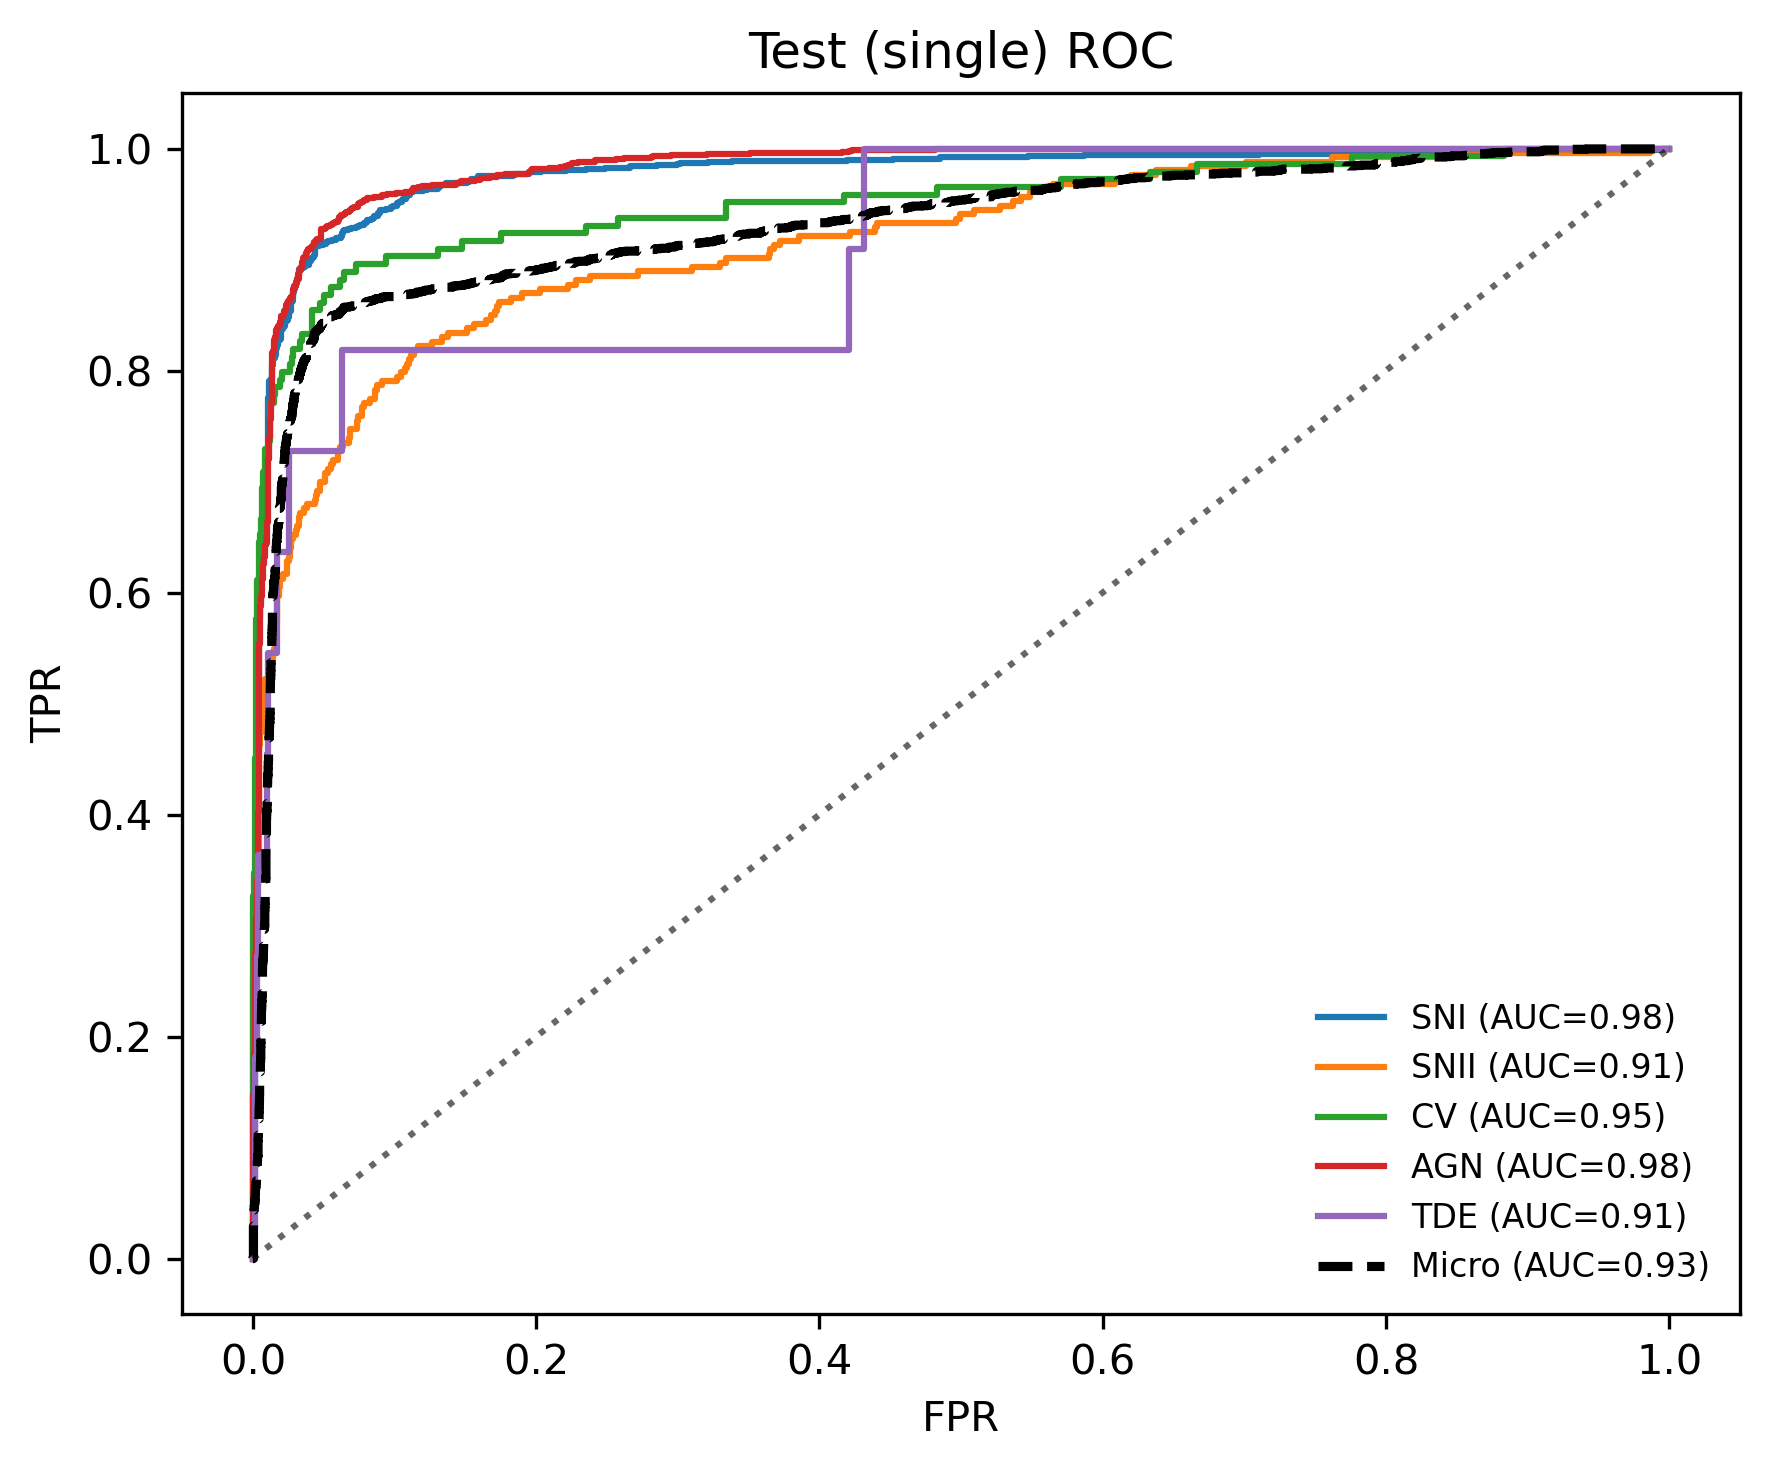

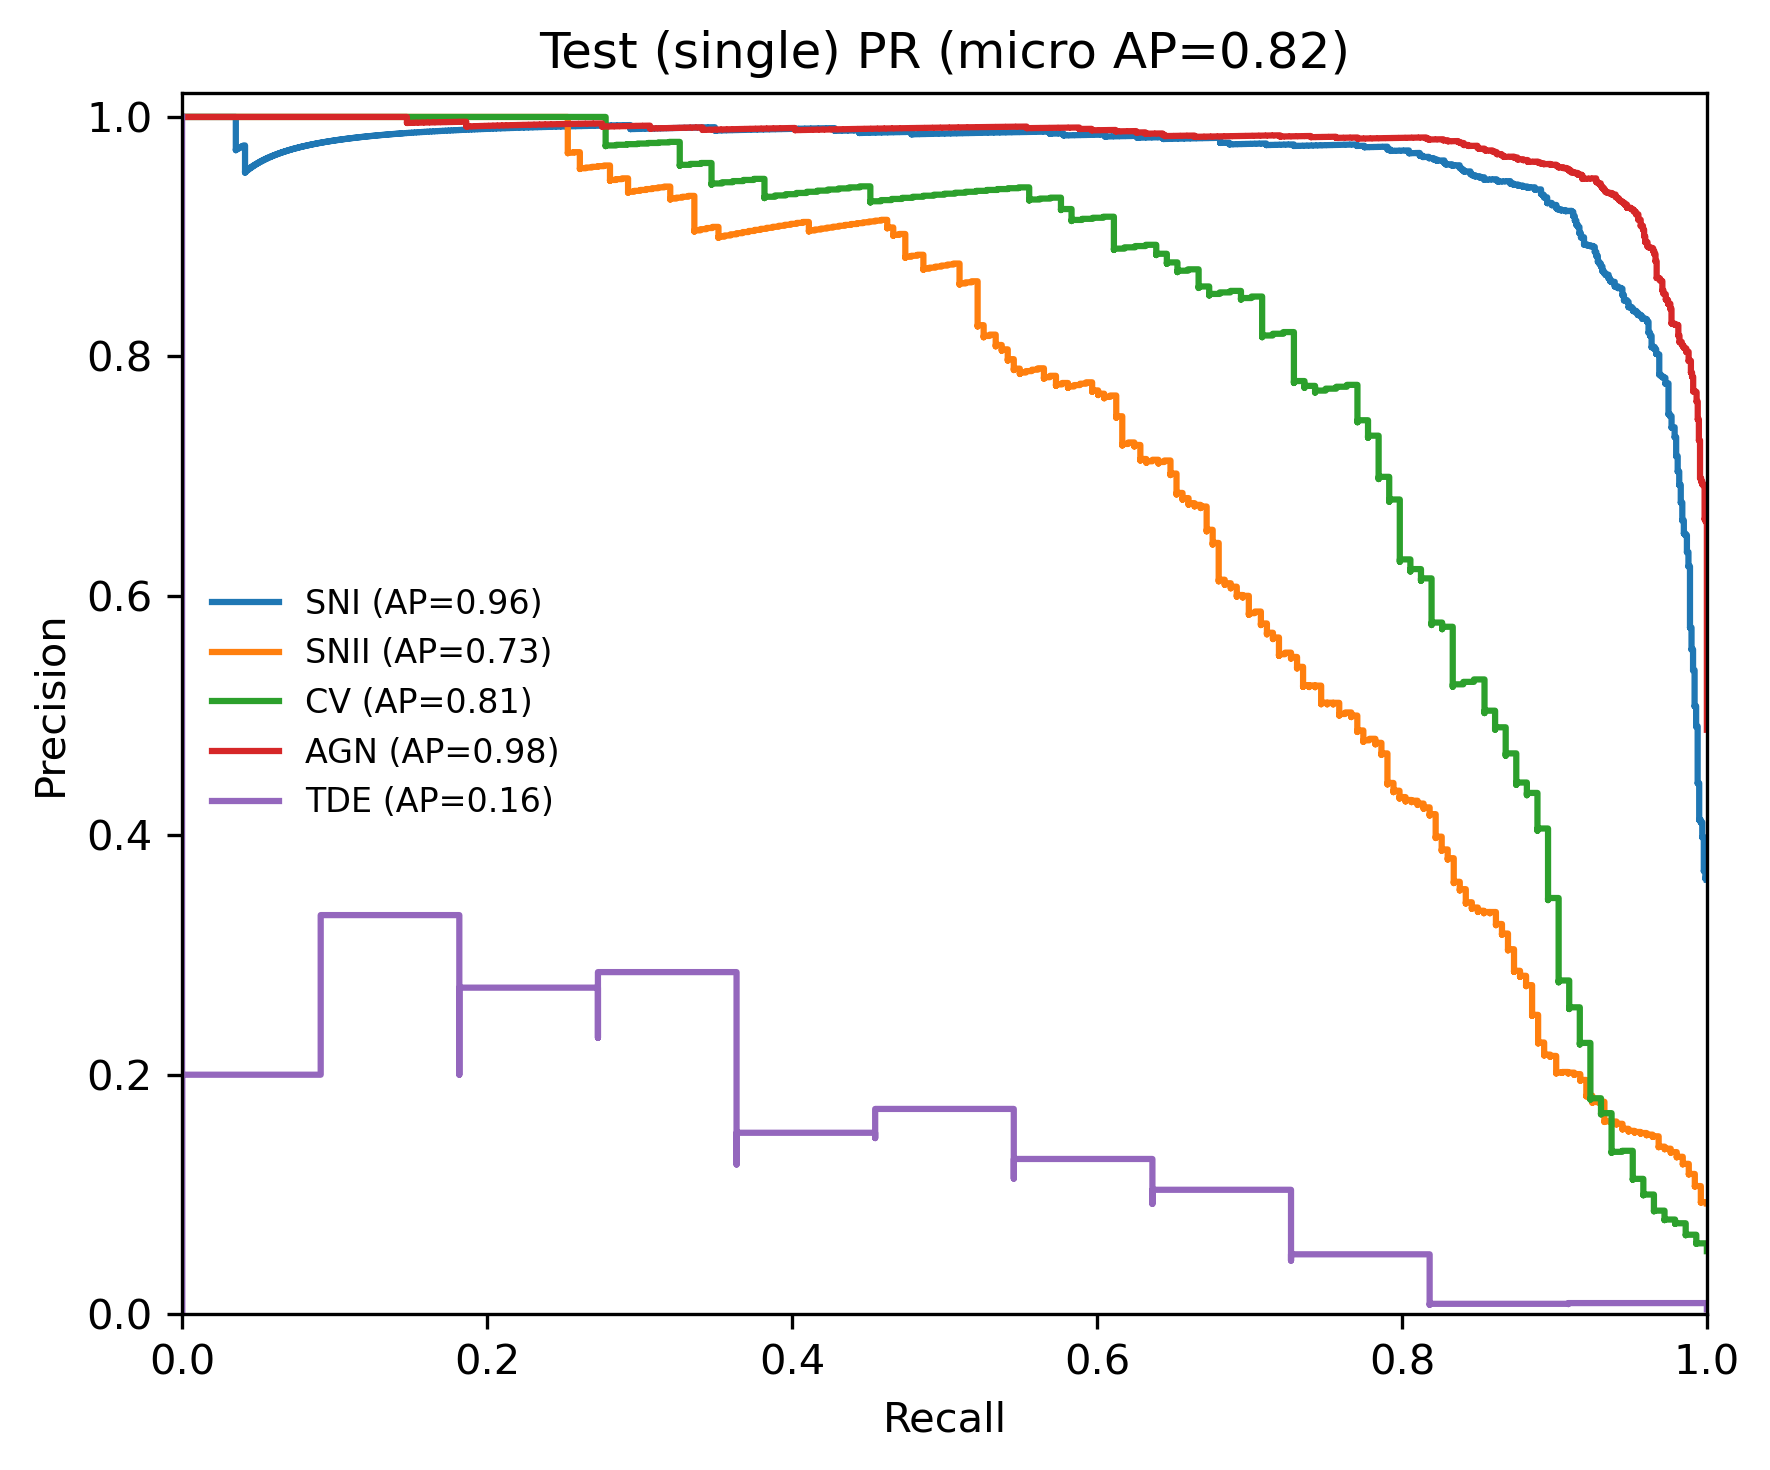

Temperature (single): T=0.523


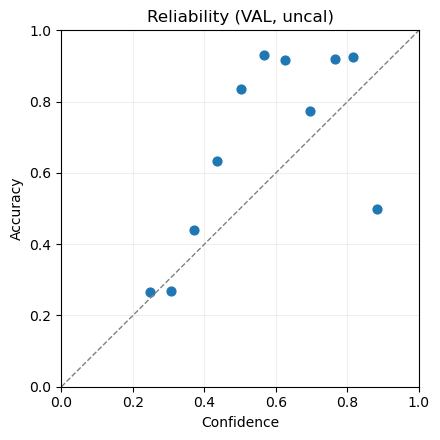

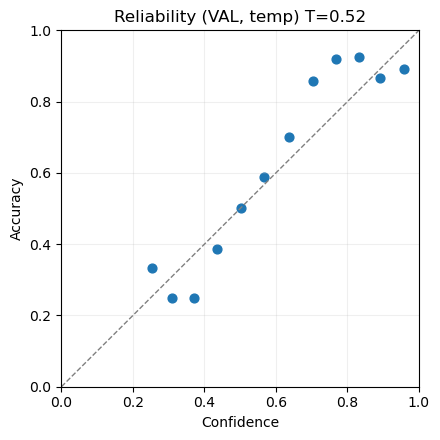

>> HYPERPARAMETER SEARCH
Create sweep with ID: rtbllgbx
Sweep URL: https://wandb.ai/feradofogo-university-of-minnesota/photometry_example/sweeps/rtbllgbx


wandb: Agent Starting Run: xzkrj0d4 with config:
wandb: 	d_model: 96
wandb: 	dropout: 0.25144855555606455
wandb: 	lr: 0.0012661678975619496
wandb: 	n_layers: 4
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /tmp/photometry_examplee_testing.ipynb.



[W&B] Trial params: lr=1.27e-03, dropout=0.25, d_model=96, n_layers=4
Loaded 2 pretrained tensors from mpt_encoder.pt (encoder only).


/tmp/ipykernel_2967243/2005479492.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(path, map_location=device)


[ft_full] EP001 | tl 0.028 | vl 0.021 | vAUPRC 0.491 | vAcc 0.576
[ft_full] EP002 | tl 0.025 | vl 0.020 | vAUPRC 0.521 | vAcc 0.602
[ft_full] EP003 | tl 0.024 | vl 0.020 | vAUPRC 0.551 | vAcc 0.643


epoch,▁▅█
train/loss,█▃▁
val/acc,▁▄█
val/auprc,▁▄█
val/loss,█▄▁
best_epoch,3
best_val_acc,0.64315
best_val_auprc,0.55099
epoch,3
train/loss,0.02369
val/acc,0.64315


wandb: Agent Starting Run: ndr8lnq4 with config:
wandb: 	d_model: 160
wandb: 	dropout: 0.037822697736648925
wandb: 	lr: 0.0008182228940417746
wandb: 	n_layers: 5
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /tmp/photometry_examplee_testing.ipynb.



[W&B] Trial params: lr=8.18e-04, dropout=0.04, d_model=160, n_layers=5
Loaded 2 pretrained tensors from mpt_encoder.pt (encoder only).


/tmp/ipykernel_2967243/2005479492.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(path, map_location=device)


[ft_full] EP001 | tl 0.026 | vl 0.020 | vAUPRC 0.528 | vAcc 0.658
[ft_full] EP002 | tl 0.022 | vl 0.019 | vAUPRC 0.593 | vAcc 0.609
[ft_full] EP003 | tl 0.020 | vl 0.018 | vAUPRC 0.657 | vAcc 0.762


epoch,▁▅█
train/loss,█▄▁
val/acc,▃▁█
val/auprc,▁▅█
val/loss,█▅▁
best_epoch,3
best_val_acc,0.76206
best_val_auprc,0.65736
epoch,3
train/loss,0.02021
val/acc,0.76206



W&B sweep — best val AUPRC=0.6574


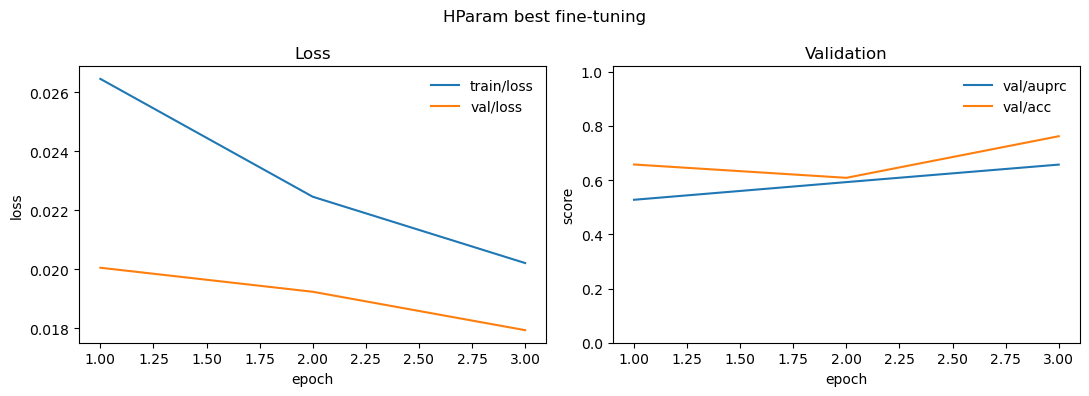

[TEST best HParam]  {'acc': 0.773109243697479, 'auprc': 0.6679077546070645, 'top2': 0.8772378516624041, 'top3': 0.9236390208257216}


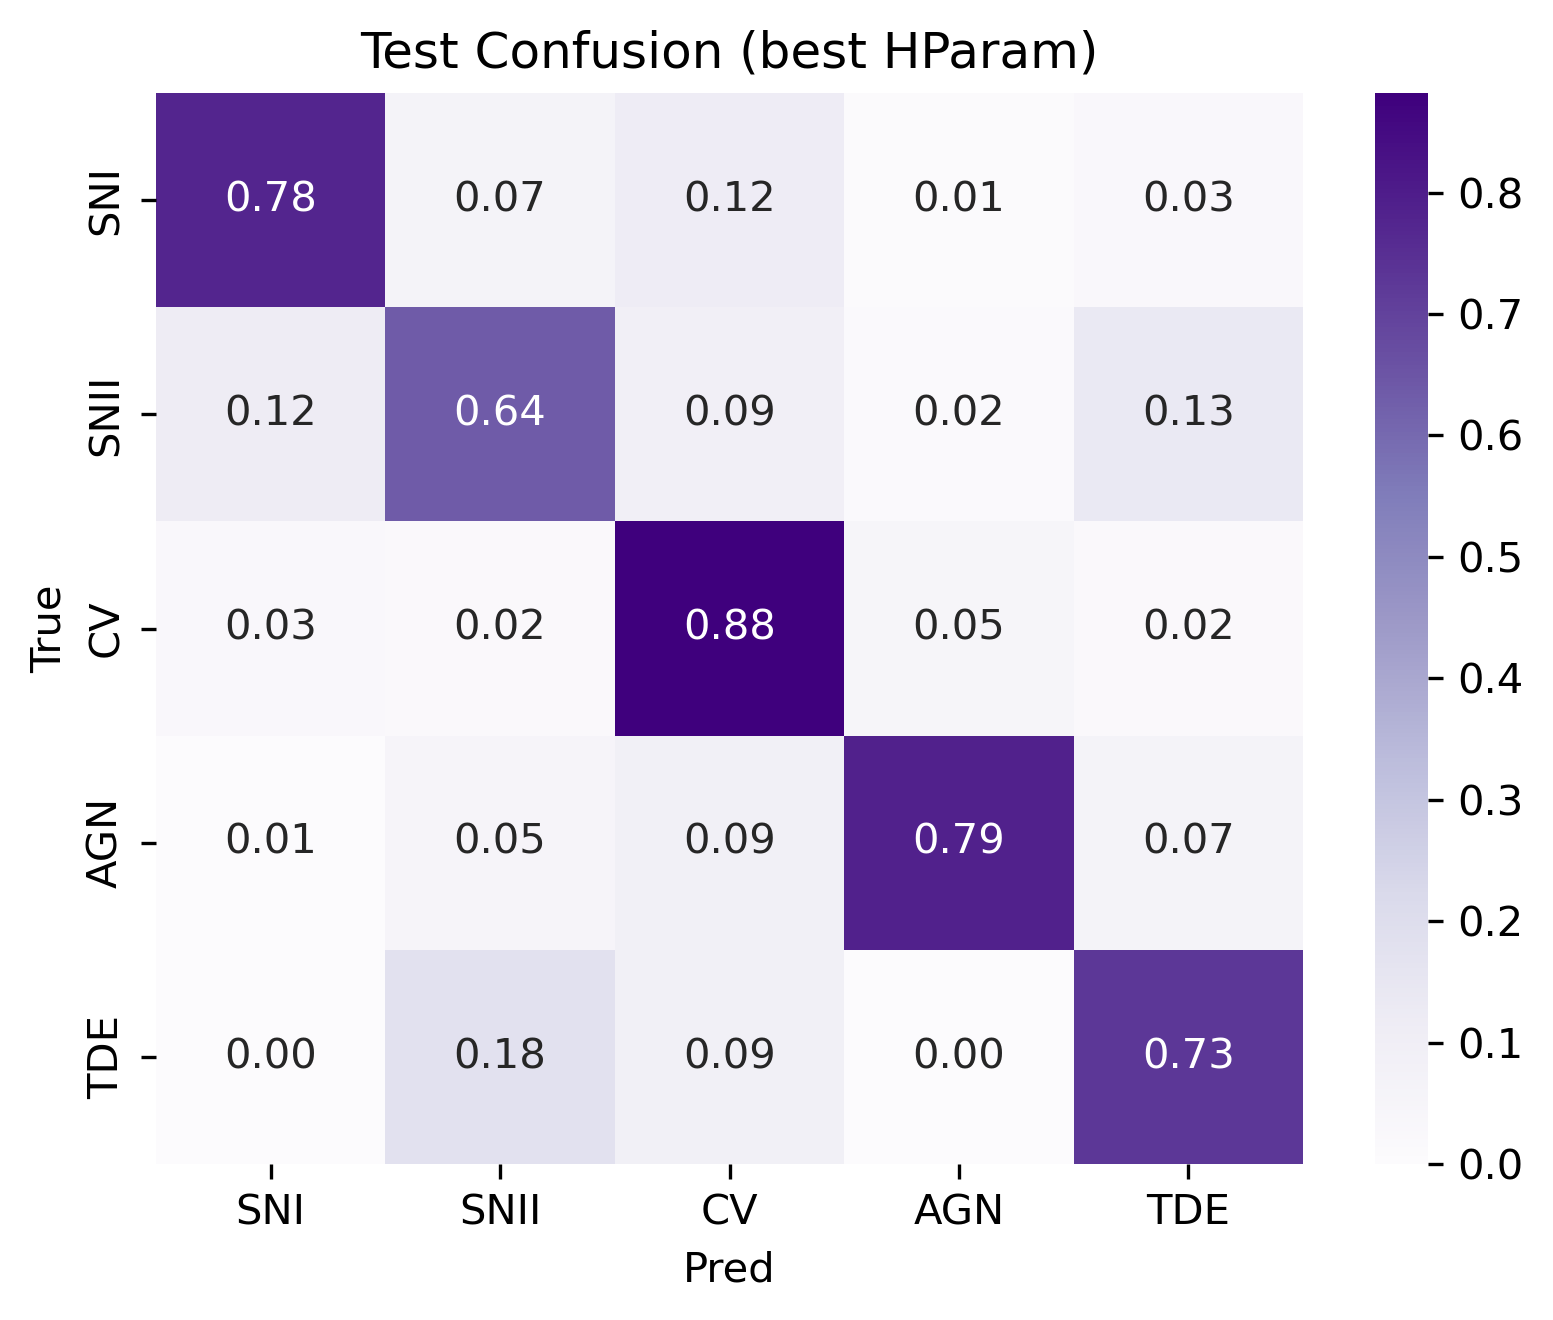

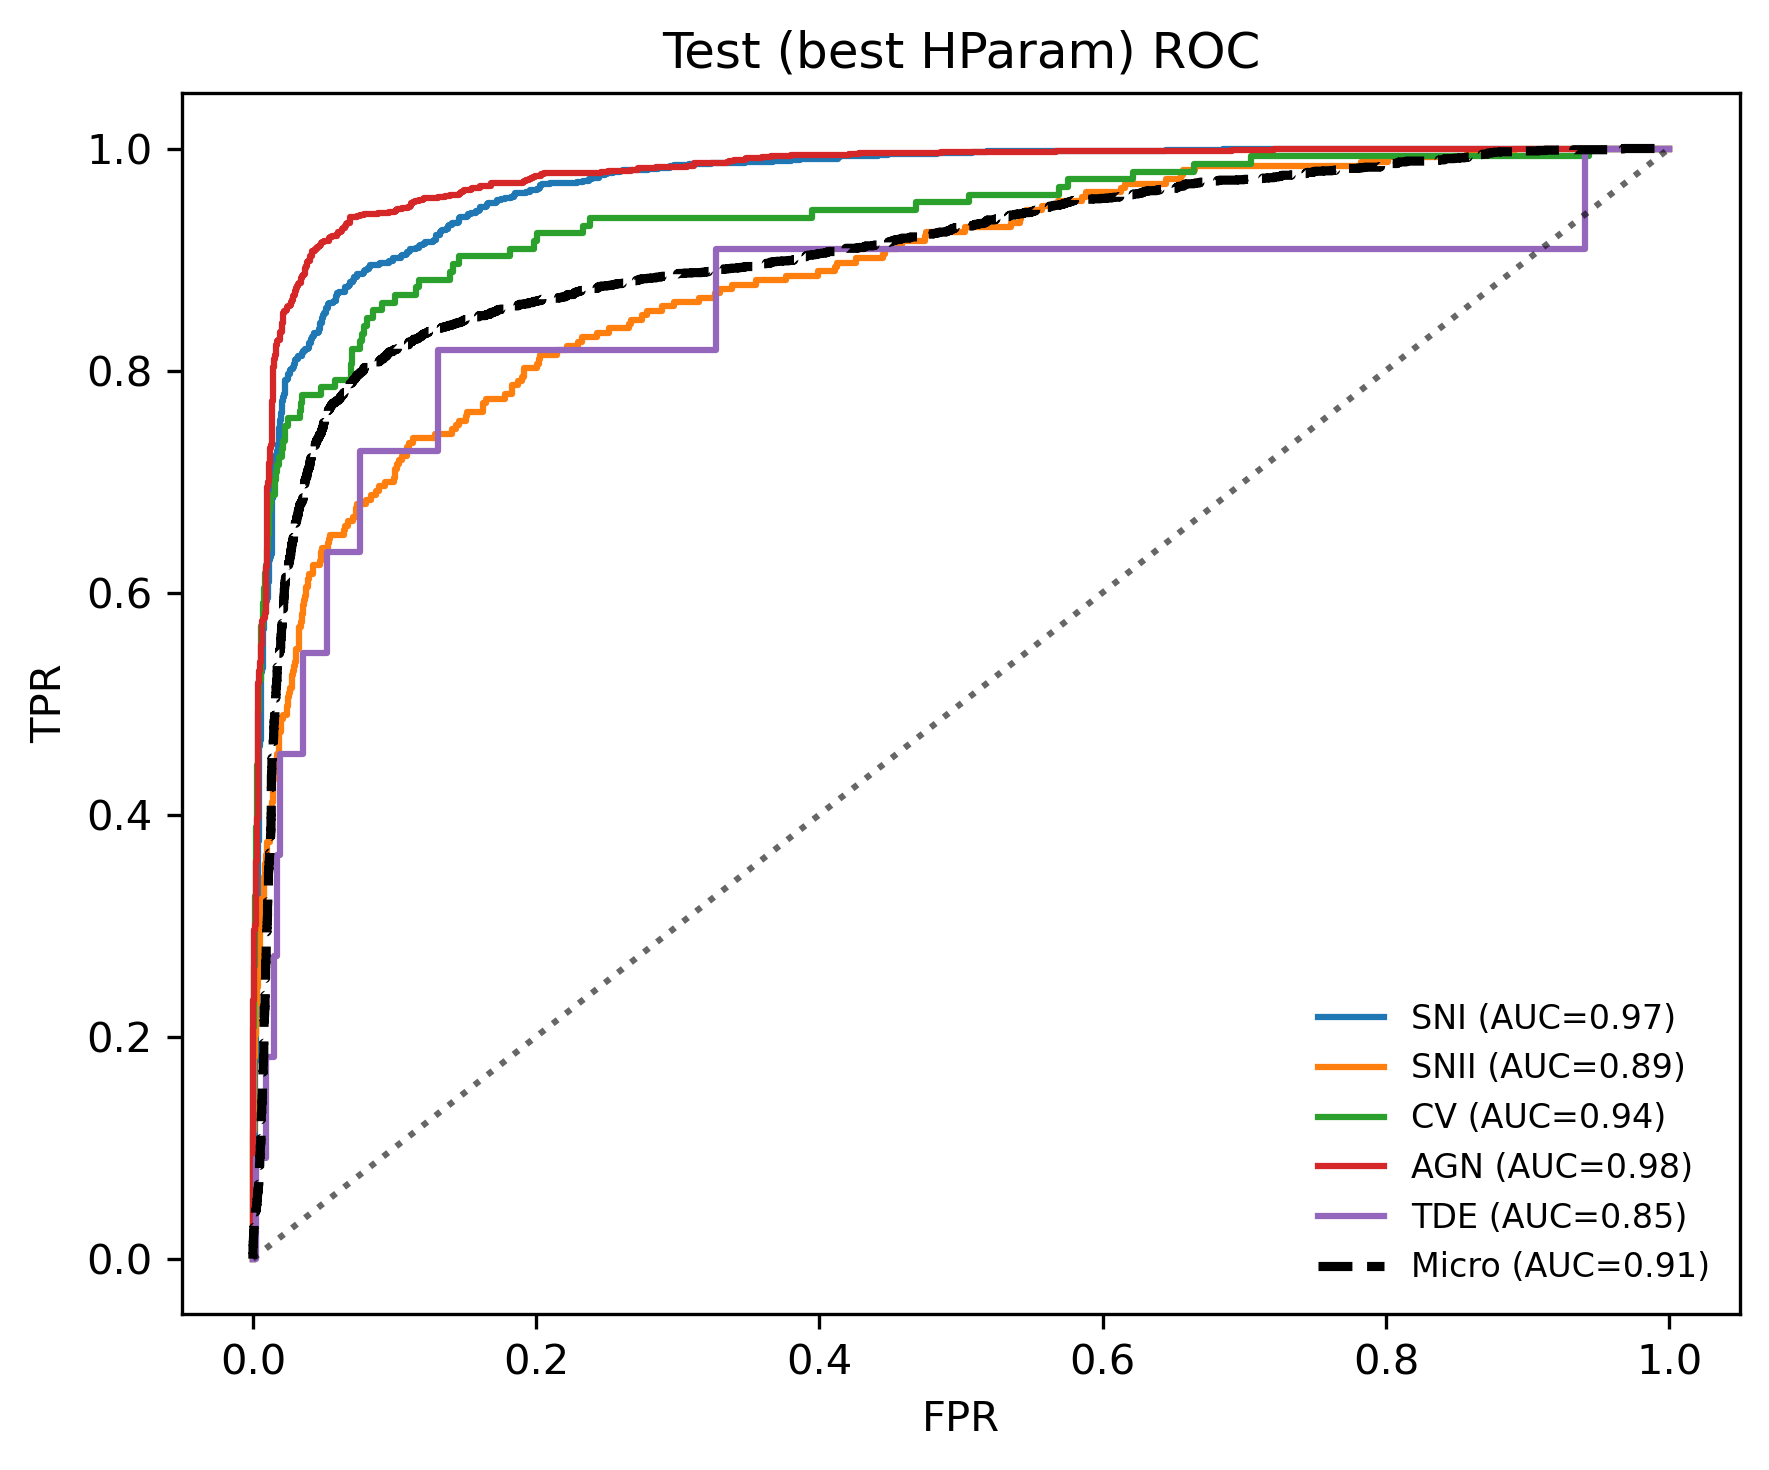

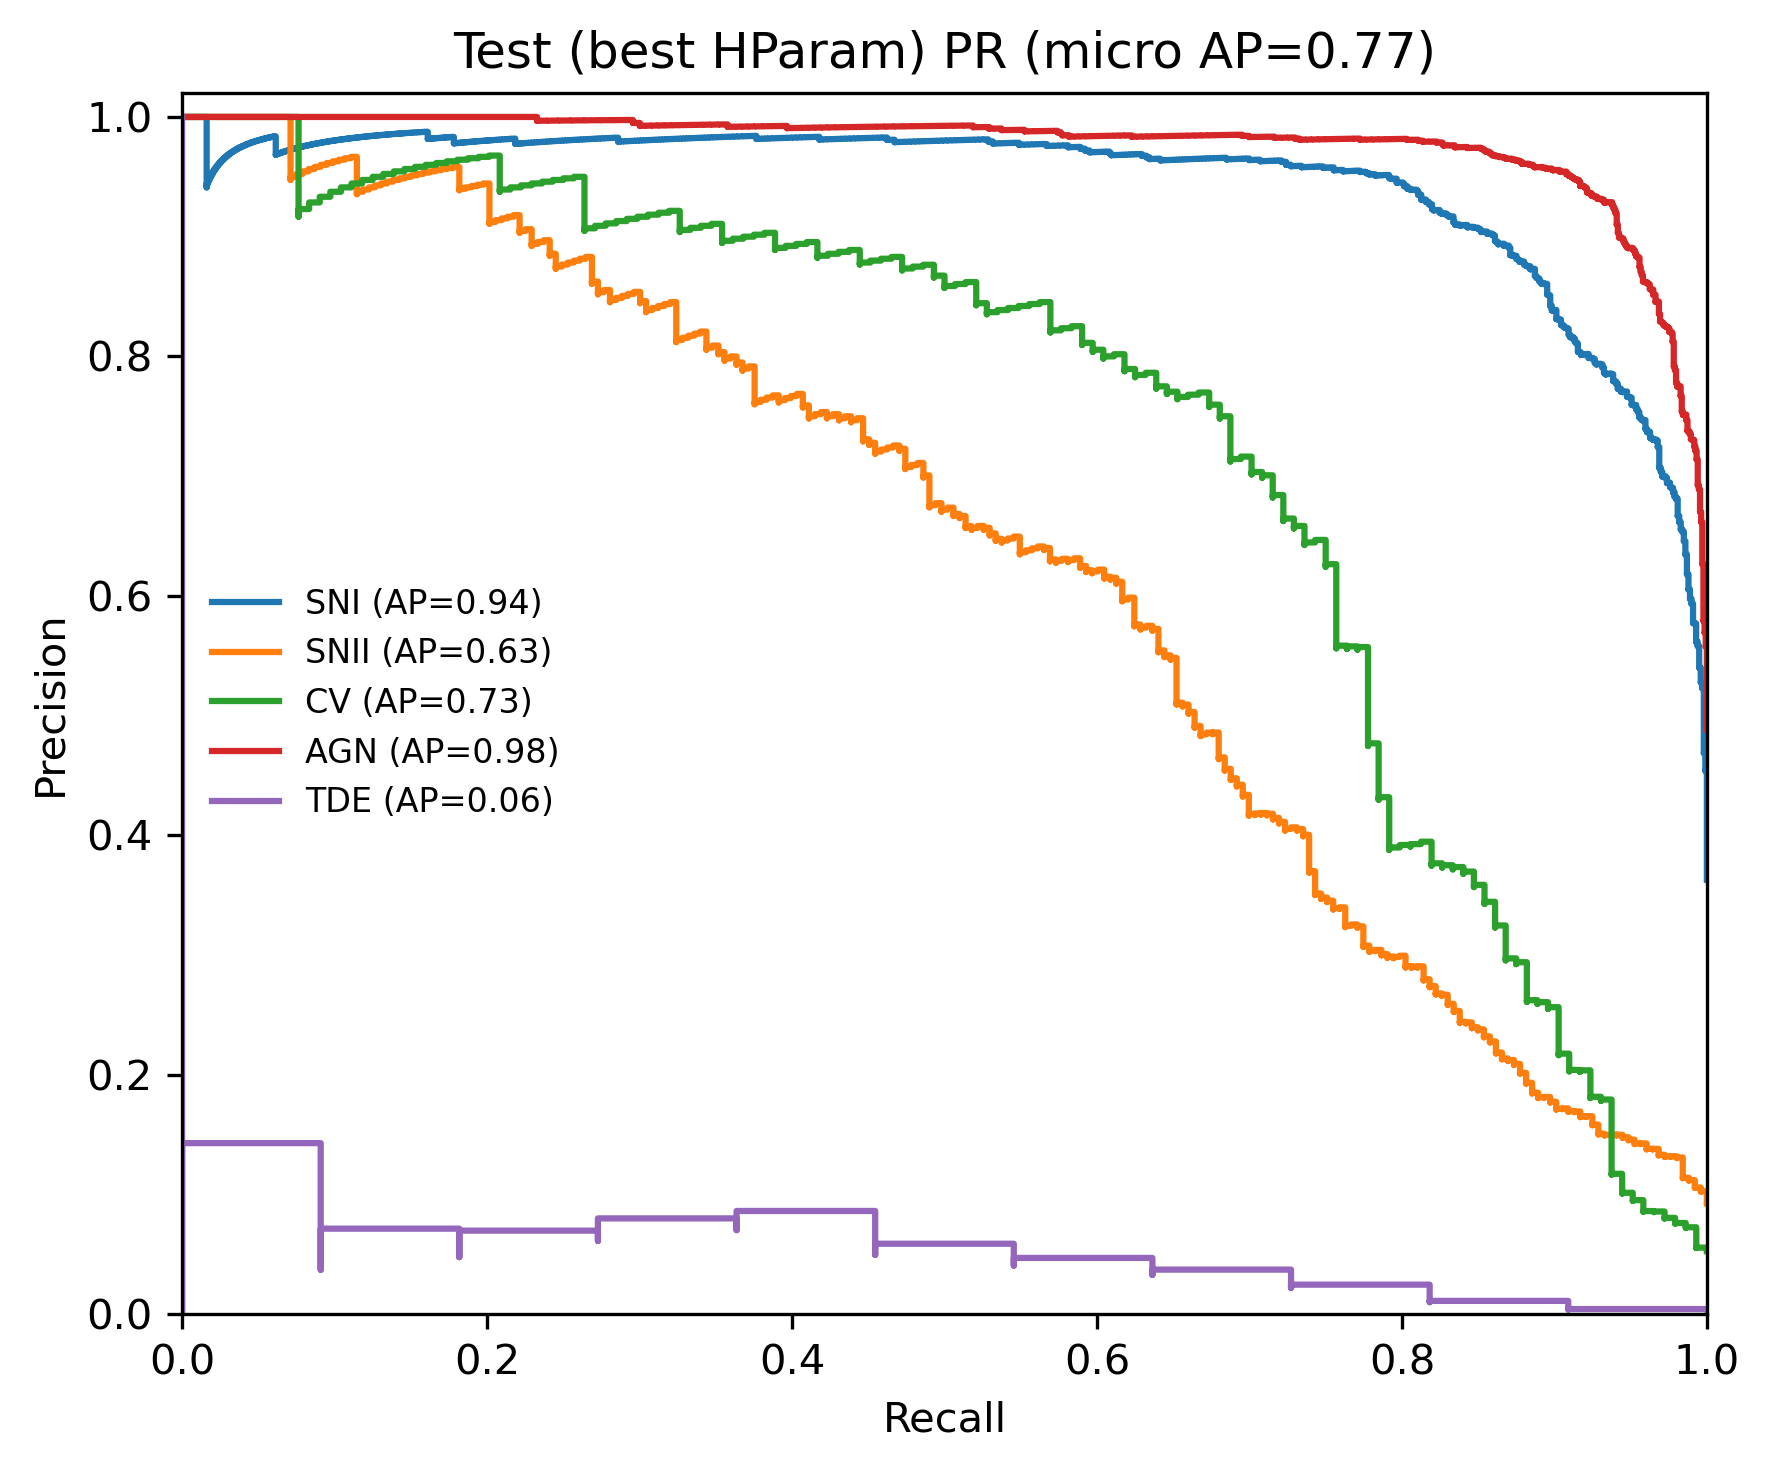

Temperature (best): T=0.480


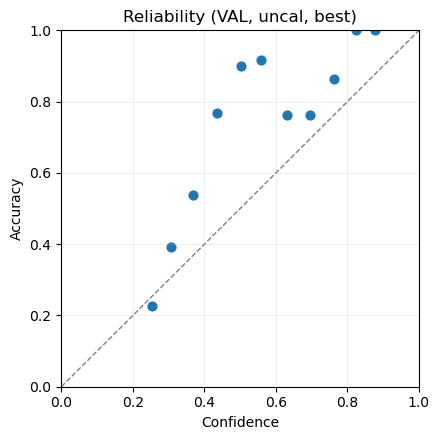

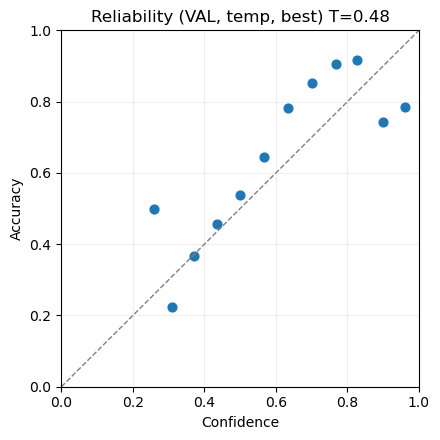


>> K-FOLD CROSS-VALIDATION

===== Fold 1/2 (full) =====
Loaded 57 pretrained tensors from mpt_encoder.pt (encoder only).


/tmp/ipykernel_2967243/2005479492.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(path, map_location=device)


[ft_full] EP001 | tl 0.030 | vl 0.022 | vAUPRC 0.464 | vAcc 0.444
[ft_full] EP002 | tl 0.026 | vl 0.020 | vAUPRC 0.506 | vAcc 0.658
[ft_full] EP003 | tl 0.024 | vl 0.020 | vAUPRC 0.560 | vAcc 0.639
[ft_full] EP004 | tl 0.023 | vl 0.019 | vAUPRC 0.604 | vAcc 0.709
[ft_full] EP005 | tl 0.022 | vl 0.018 | vAUPRC 0.638 | vAcc 0.742
[ft_full] EP006 | tl 0.021 | vl 0.018 | vAUPRC 0.667 | vAcc 0.782
[ft_full] EP007 | tl 0.020 | vl 0.018 | vAUPRC 0.685 | vAcc 0.779
[ft_full] EP008 | tl 0.020 | vl 0.017 | vAUPRC 0.701 | vAcc 0.802
[ft_full] EP009 | tl 0.019 | vl 0.017 | vAUPRC 0.712 | vAcc 0.802
[ft_full] EP010 | tl 0.019 | vl 0.017 | vAUPRC 0.723 | vAcc 0.805

===== Fold 2/2 (full) =====
Loaded 57 pretrained tensors from mpt_encoder.pt (encoder only).


/tmp/ipykernel_2967243/2005479492.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(path, map_location=device)


[ft_full] EP001 | tl 0.030 | vl 0.022 | vAUPRC 0.463 | vAcc 0.528
[ft_full] EP002 | tl 0.025 | vl 0.021 | vAUPRC 0.499 | vAcc 0.581
[ft_full] EP003 | tl 0.024 | vl 0.020 | vAUPRC 0.558 | vAcc 0.671
[ft_full] EP004 | tl 0.022 | vl 0.019 | vAUPRC 0.621 | vAcc 0.699
[ft_full] EP005 | tl 0.021 | vl 0.018 | vAUPRC 0.658 | vAcc 0.728
[ft_full] EP006 | tl 0.020 | vl 0.018 | vAUPRC 0.693 | vAcc 0.765
[ft_full] EP007 | tl 0.020 | vl 0.017 | vAUPRC 0.714 | vAcc 0.762
[ft_full] EP008 | tl 0.019 | vl 0.017 | vAUPRC 0.715 | vAcc 0.795
[ft_full] EP009 | tl 0.019 | vl 0.017 | vAUPRC 0.735 | vAcc 0.814
[ft_full] EP010 | tl 0.018 | vl 0.017 | vAUPRC 0.733 | vAcc 0.792

CV summary per fold:


,fold,acc,auprc,top2,top3,best_val_auprc
0,0,0.812934,0.712004,0.892583,0.941542,0.723115
1,1,0.824260,0.713786,0.909390,0.948849,0.734998



CV mean ± std:


,fold,acc,auprc,top2,top3,best_val_auprc
mean,0.500000,0.818597,0.712895,0.900986,0.945195,0.729057
std,0.707107,0.008009,0.001260,0.011884,0.005167,0.008402


In [25]:
# =========================
# Example Smoke-test 
# =========================
# This runs:
#  1) Single finetune
#  2) Calibration
#  3) Tiny HParam search (if enabled)
#  4) Calibration of best trial
#  5) K-Fold cross-validation (if enabled)

# (A) Single finetune
print(">> SINGLE FINETUNE")
out_single = run_finetune(CFG)
plot_loss_curves(out_single["curves"], title=f"{CFG.finetune_strategy.upper()} fine-tuning")
# Evaluate & plot test
_, _, test_ld = out_single["loaders"]
m_single, (y_t, P_t, L_t) = summarize_on_loader(out_single["model"], test_ld)
print("[TEST single] ", m_single)
plot_confusion(y_t, P_t.argmax(1), title="Test Confusion (single)")
plot_roc_pr(y_t, P_t, title_prefix="Test (single)")

# (B) Calibration after single
cal_single = calibrate_if_enabled(CFG, out_single["model"], out_single["loaders"])
if cal_single is not None:
    print(f"Temperature (single): T={cal_single['T']:.3f}")
    # Plot reliability (VAL pre/post)
    plot_reliability_diagram(cal_single["val"]["bins_unc"], title="Reliability (VAL, uncal)")
    plot_reliability_diagram(cal_single["val"]["bins_cal"], title=f"Reliability (VAL, temp) T={cal_single['T']:.2f}")
    # one could re-plot ROC/PR...

# (C) Tiny HParam search (very fast for smoke test)
print(">> HYPERPARAMETER SEARCH")
best = None
if CFG.hps_enabled:
    (best_cfg, best_out), trials = tiny_hparam_search(copy.deepcopy(CFG), grid=CFG.hps_grid, max_trials=CFG.hps_max_trials)
    best = (best_cfg, best_out)
    plot_loss_curves(best_out["curves"], title="HParam best fine-tuning")
    _, _, test_ld_best = best_out["loaders"]
    m_best, (y_best, P_best, L_best) = summarize_on_loader(best_out["model"], test_ld_best)
    print("[TEST best HParam] ", m_best)
    plot_confusion(y_best, P_best.argmax(1), title="Test Confusion (best HParam)")
    plot_roc_pr(y_best, P_best, title_prefix="Test (best HParam)")

    # (D) Calibration of best
    cal_best = calibrate_if_enabled(best_cfg, best_out["model"], best_out["loaders"])
    if cal_best is not None:
        print(f"Temperature (best): T={cal_best['T']:.3f}")
        plot_reliability_diagram(cal_best["val"]["bins_unc"], title="Reliability (VAL, uncal, best)")
        plot_reliability_diagram(cal_best["val"]["bins_cal"], title=f"Reliability (VAL, temp, best) T={cal_best['T']:.2f}")

# (E) K-fold CV
if CFG.k_folds and CFG.k_folds >= 2:
    print("\n>> K-FOLD CROSS-VALIDATION")
    df_cv, preds_cv = run_crossval_finetune(copy.deepcopy(CFG))
